In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import random_split


In [17]:
from torchvision.datasets import FashionMNIST

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, resize_transform=None, target_transform=None):
        self.data = data
        self.resize_transform = resize_transform
        self.target_transform = target_transform
        self.targets = [label for _, label in data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]

        if self.target_transform:
            original_image = self.target_transform(image)

        if self.resize_transform:
            resized_image = self.resize_transform(image)

        return resized_image, original_image,label


In [18]:

resize_transform = transforms.Compose([
    transforms.Resize((7,7)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

target_transform_train = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,)),
])

target_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])


In [20]:
train_dataset_original = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
test_dataset_original  = torchvision.datasets.FashionMNIST(root='data', train=False, download=True)


In [21]:
train_dataset = CustomDataset(train_dataset_original,resize_transform=resize_transform, target_transform=target_transform_train)
test_dataset = CustomDataset(test_dataset_original, resize_transform=resize_transform, target_transform=target_transform_test)


In [22]:
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])


In [23]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [219]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=1, padding=0),  # 7x7 -> 5x5
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        # Adjust the number of input features to match the output of the last conv layer
        self.encoder_lin = nn.Sequential(
            nn.Linear(16 * 5 * 5, 128),  # 16 --> last conv layer, 5--> 5x5 last conv dimension
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        #print(f"Shape initially inside encoder: {x.shape}")
        x = self.encoder_cnn(x)
        #print(f"Shape after encoder cnn: {x.shape}")
        x = self.flatten(x)
        #print(f"Shape after flatten: {x.shape}")
        x = self.encoder_lin(x)
        #print(f"Shape after encoder linear: {x.shape}")
        return x


In [220]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        #self.decoder_lin = nn.Linear(128, 16 * 5 * 5)

        self.decoder_lin = nn.Sequential(
           nn.Linear(encoded_space_dim, 128),
           nn.ReLU(True),
           nn.Linear(128, 16*5*5),
           nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(1, (16, 5, 5))

        # [5x5] to [7x7]
        self.upconv1 =nn.Sequential(
          nn.ConvTranspose2d(16,16, kernel_size=3, stride=1, padding=0),
          nn.BatchNorm2d(16),
          nn.ReLU(True)
        )
        self.upconv2 = nn.Sequential(
          nn.ConvTranspose2d(16,8,kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(8),
          nn.ReLU(True)
        )
        self.upconv3 = nn.Sequential(
          nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(True)
        )
        self.final_conv = nn.Sequential(
          nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(1),
          nn.ReLU(True)
        )

    def forward(self, x):
        #print(f"Shape initially inside decoder: {x.shape}")
        x = self.decoder_lin(x)
        #print(f"Shape after decoder linear: {x.shape}")
        x = self.unflatten(x)
        #print(f"Shape after unflatten: {x.shape}")

        x = self.upconv1(x)
        #print(f"Shape after first convolutional: {x.shape}")
        x = self.upconv2(x)
        #print(f"Shape after second conv: {x.shape}")
        x = self.upconv3(x)
        #print(f"Shape after third conv: {x.shape}")
        x = self.final_conv(x)
        #print(f"Shape after final conv: {x.shape}")
        #x = torch.sigmoid(x)

        #print(f"Shape after sigmoid: {x.shape}")
        return x


In [209]:
class Encoder_2(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            # nn.Linear(16 * 7 * 7, 128),
            # nn.ReLU(True),
            nn.Linear(32*5*5, encoded_space_dim),
            # nn.Linear(128, encoded_space_dim),
            nn.ReLU(True),
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        #print(f"Shape after encoder cnn: {x.shape}")
        x = self.flatten(x)
        #print(f"Shape after flatten: {x.shape}")
        x = self.encoder_lin(x)
        #print(f"Shape after encoder lin: {x.shape}")
        return x

class Decoder_2(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim ):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            # nn.Linear(encoded_space_dim, 128),
            nn.Linear(encoded_space_dim, 32*5*5),
            nn.ReLU(True),
            # nn.Linear(128, 16*7*7),
            # nn.ReLU(True),
        )
        self.unflatten = nn.Unflatten(1, (32, 5, 5))

        self.upconv1 =nn.Sequential(
          nn.ConvTranspose2d(32,16, kernel_size=3, stride=1, padding=0),
          nn.BatchNorm2d(16),
          nn.ReLU(True)
        )
        self.upconv2 = nn.Sequential(
          nn.ConvTranspose2d(16,8,kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(8),
          nn.ReLU(True)
        )
        self.upconv3 = nn.Sequential(
          nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(4),
          nn.ReLU(True)
        )
        self.final_conv = nn.Sequential(
          nn.ConvTranspose2d(4, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        #print(f"Shape initially inside decoder: {x.shape}")
        x = self.decoder_lin(x)
        #print(f"Shape after decoder linear: {x.shape}")
        x = self.unflatten(x)
        #print(f"Shape after unflatten: {x.shape}")

        x = self.upconv1(x)
        #print(f"Shape after first convolutional: {x.shape}")
        x = self.upconv2(x)
        #print(f"Shape after second conv: {x.shape}")
        x = self.upconv3(x)
        #print(f"Shape after third conv: {x.shape}")
        x = self.final_conv(x)
        #print(f"Shape after final conv: {x.shape}")
        #x = torch.sigmoid(x)
        return x

In [296]:
class Encoder_3(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        # one convolutional layer
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 7x7 -> 4x4
            nn.BatchNorm2d(16),
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(16 * 4 * 4, 128),  # 16 channels and 4x4 dimension
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        print(f"Shape after encoder cnn: {x.shape}")
        x = self.flatten(x)
        print(f"Shape after flatten: {x.shape}")
        x = self.encoder_lin(x)
        print(f"Shape after encoder lin: {x.shape}")
        return x


class Decoder_3(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 16*4*4),  # 4x4x16
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(1, (16, 4, 4))

        # [4x4] to [7x7]
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1),  # 4x4 -> 7x7
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )
        # [7x7] to [14x14]
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(8),
            nn.ReLU(True)
        )
        # [14x14] to [28x28]
        self.final_conv = nn.Sequential(
            nn.ConvTranspose2d(8, 1, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.BatchNorm2d(1),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        print(f"Shape after decoder lin: {x.shape}")
        x = self.unflatten(x)
        print(f"Shape after unflatten: {x.shape}")
        x = self.upconv1(x)
        print(f"Shape after conv1: {x.shape}")
        x = self.upconv2(x)
        print(f"Shape after conv2: {x.shape}")
        x = self.final_conv(x)
        print(f"Shape after conv3: {x.shape}")
        return x


In [221]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.0001

### Set the random seed for reproducible results

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder= Decoder(encoded_space_dim=d,fc2_input_dim=128)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


In [222]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=400, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 5, 5))
  (upconv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv3): Sequential(
    (0): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (final_conv): Sequential(
    (0): ConvTranspose

In [70]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for resized_image,original_image, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device

        resized_image = resized_image.to(device)
        #print(f"Shape of resized image: {resized_image.shape}")
        # Encode data
        encoded_data = encoder(resized_image)
        #print(f"Shape of encoded data: {encoded_data.shape}")
        # Decode data
        decoded_data = decoder(encoded_data)
        #print(f"Shape of decoded data: {decoded_data.shape}")
        # Evaluate loss
        #optimizer.zero_grad()
        original_image = original_image.to(device)
        loss = loss_fn(decoded_data, original_image)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


In [29]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for resized_image,original_image, _ in dataloader:
            # Move tensor to the proper device
            resized_image = resized_image.to(device)
            # Encode data
            encoded_data = encoder(resized_image)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data)
            original_image = original_image.to(device)
            conc_label.append(original_image)
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [30]:
def plot_ae_outputs_random_indx(encoder, decoder, test_dataset, device, n=10):
    plt.figure(figsize=(16, 4.5))

    # Get 'n' unique indices from the test dataset
    indices = np.random.choice(len(test_dataset), n, replace=False)

    for i, idx in enumerate(indices):
        # Get the resized and original images
        resized_img, original_img, _ = test_dataset[idx]

        # Add batch dimension and transfer to the device
        resized_img = resized_img.unsqueeze(0).to(device)

        # Set the model to evaluation mode and generate the reconstructed image
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(resized_img))

        # Plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_img.squeeze().numpy(), cmap='gray')
        ax.axis('off')
        if i == n // 2:
            ax.set_title('Original images')

        # Plot reconstructed image
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')
        if i == n // 2:
            ax.set_title('Reconstructed images with random choices')

    plt.show()


In [31]:
def plot_ae_outputs_same_set(encoder, decoder, test_dataset, device, indices):
    plt.figure(figsize=(16, 4.5))

    for i, idx in enumerate(indices):
        # Get the resized and original images
        resized_img, original_img, _ = test_dataset[idx]

        # Add batch dimension and transfer to the device
        resized_img = resized_img.unsqueeze(0).to(device)

        # Set the model to evaluation mode and generate the reconstructed image
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(resized_img))

        # Plot original image
        ax = plt.subplot(2, len(indices), i + 1)
        plt.imshow(original_img.squeeze().numpy(), cmap='gray')
        ax.axis('off')
        if i == len(indices) // 2:
            ax.set_title('Original images')

        # Plot reconstructed image
        ax = plt.subplot(2, len(indices), len(indices) + i + 1)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')
        if i == len(indices) // 2:
            ax.set_title('Reconstructed images with same indices')

    plt.show()


In [32]:
num_classes = 10
indices_per_class = 1
fixed_indices = []
for class_idx in range(num_classes):
    class_indices = np.where(np.array(test_dataset.targets) == class_idx)[0]
    class_specific_indices = np.random.choice(class_indices, indices_per_class, replace=False)
    fixed_indices.extend(class_specific_indices)

	 partial train loss (single batch): 1.504622
	 partial train loss (single batch): 1.498779
	 partial train loss (single batch): 1.521780
	 partial train loss (single batch): 1.434802
	 partial train loss (single batch): 1.500770
	 partial train loss (single batch): 1.379935
	 partial train loss (single batch): 1.443602
	 partial train loss (single batch): 1.472157
	 partial train loss (single batch): 1.348874
	 partial train loss (single batch): 1.459457
	 partial train loss (single batch): 1.350714
	 partial train loss (single batch): 1.303186
	 partial train loss (single batch): 1.415531
	 partial train loss (single batch): 1.367666
	 partial train loss (single batch): 1.373059
	 partial train loss (single batch): 1.350457
	 partial train loss (single batch): 1.377153
	 partial train loss (single batch): 1.368761
	 partial train loss (single batch): 1.376407
	 partial train loss (single batch): 1.277206
	 partial train loss (single batch): 1.347000
	 partial train loss (single batch

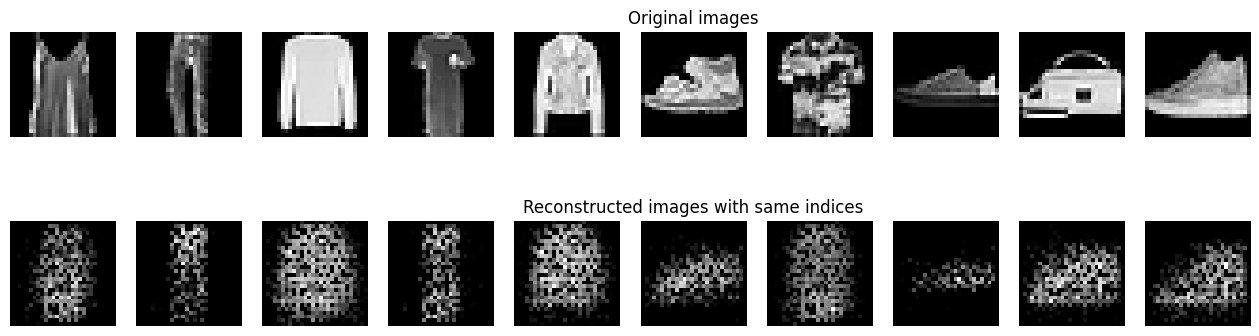

	 partial train loss (single batch): 0.795901
	 partial train loss (single batch): 0.746787
	 partial train loss (single batch): 0.823531
	 partial train loss (single batch): 0.806830
	 partial train loss (single batch): 0.870892
	 partial train loss (single batch): 0.874215
	 partial train loss (single batch): 0.799294
	 partial train loss (single batch): 0.856452
	 partial train loss (single batch): 0.799721
	 partial train loss (single batch): 0.761974
	 partial train loss (single batch): 0.876847
	 partial train loss (single batch): 0.830209
	 partial train loss (single batch): 0.810946
	 partial train loss (single batch): 0.797588
	 partial train loss (single batch): 0.877801
	 partial train loss (single batch): 0.818516
	 partial train loss (single batch): 0.867500
	 partial train loss (single batch): 0.772427
	 partial train loss (single batch): 0.832198
	 partial train loss (single batch): 0.760289
	 partial train loss (single batch): 0.869637
	 partial train loss (single batch

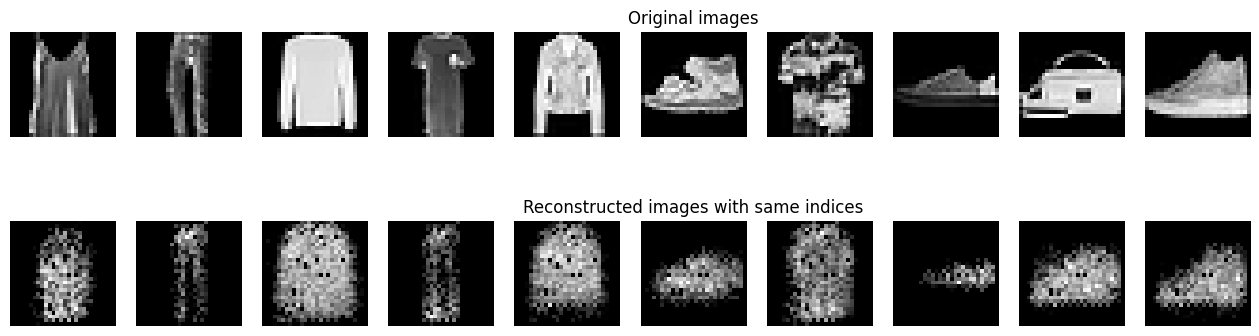

	 partial train loss (single batch): 0.534472
	 partial train loss (single batch): 0.552245
	 partial train loss (single batch): 0.552051
	 partial train loss (single batch): 0.521227
	 partial train loss (single batch): 0.541599
	 partial train loss (single batch): 0.549047
	 partial train loss (single batch): 0.545495
	 partial train loss (single batch): 0.521877
	 partial train loss (single batch): 0.544819
	 partial train loss (single batch): 0.563485
	 partial train loss (single batch): 0.580048
	 partial train loss (single batch): 0.518813
	 partial train loss (single batch): 0.568215
	 partial train loss (single batch): 0.543505
	 partial train loss (single batch): 0.555486
	 partial train loss (single batch): 0.546955
	 partial train loss (single batch): 0.541031
	 partial train loss (single batch): 0.531314
	 partial train loss (single batch): 0.516676
	 partial train loss (single batch): 0.533405
	 partial train loss (single batch): 0.542998
	 partial train loss (single batch

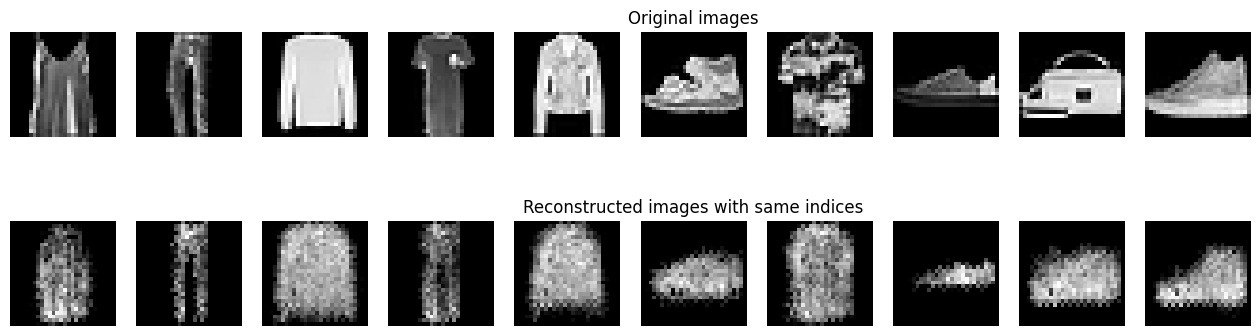

	 partial train loss (single batch): 0.501426
	 partial train loss (single batch): 0.427655
	 partial train loss (single batch): 0.458933
	 partial train loss (single batch): 0.423090
	 partial train loss (single batch): 0.480588
	 partial train loss (single batch): 0.441809
	 partial train loss (single batch): 0.438324
	 partial train loss (single batch): 0.458440
	 partial train loss (single batch): 0.421880
	 partial train loss (single batch): 0.457406
	 partial train loss (single batch): 0.442667
	 partial train loss (single batch): 0.434868
	 partial train loss (single batch): 0.439729
	 partial train loss (single batch): 0.432044
	 partial train loss (single batch): 0.424699
	 partial train loss (single batch): 0.454629
	 partial train loss (single batch): 0.434628
	 partial train loss (single batch): 0.473544
	 partial train loss (single batch): 0.444994
	 partial train loss (single batch): 0.416073
	 partial train loss (single batch): 0.444605
	 partial train loss (single batch

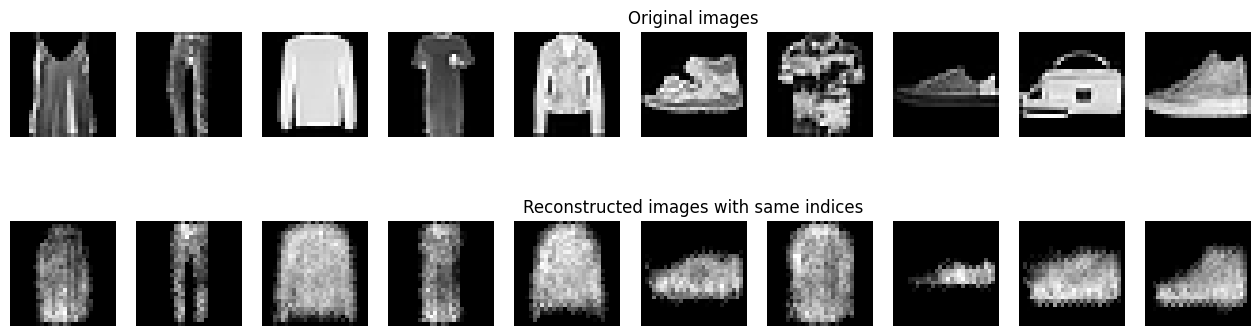

	 partial train loss (single batch): 0.374979
	 partial train loss (single batch): 0.446567
	 partial train loss (single batch): 0.365529
	 partial train loss (single batch): 0.409476
	 partial train loss (single batch): 0.411994
	 partial train loss (single batch): 0.404118
	 partial train loss (single batch): 0.372348
	 partial train loss (single batch): 0.406980
	 partial train loss (single batch): 0.403997
	 partial train loss (single batch): 0.404059
	 partial train loss (single batch): 0.390448
	 partial train loss (single batch): 0.369029
	 partial train loss (single batch): 0.403654
	 partial train loss (single batch): 0.386609
	 partial train loss (single batch): 0.402115
	 partial train loss (single batch): 0.403458
	 partial train loss (single batch): 0.380013
	 partial train loss (single batch): 0.370703
	 partial train loss (single batch): 0.385083
	 partial train loss (single batch): 0.347303
	 partial train loss (single batch): 0.396763
	 partial train loss (single batch

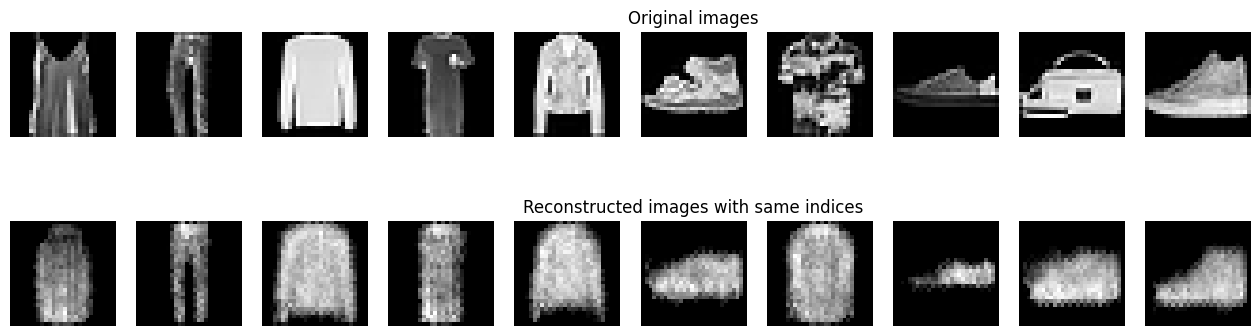

	 partial train loss (single batch): 0.396719
	 partial train loss (single batch): 0.382454
	 partial train loss (single batch): 0.384406
	 partial train loss (single batch): 0.373157
	 partial train loss (single batch): 0.368238
	 partial train loss (single batch): 0.404406
	 partial train loss (single batch): 0.355736
	 partial train loss (single batch): 0.373819
	 partial train loss (single batch): 0.361533
	 partial train loss (single batch): 0.412524
	 partial train loss (single batch): 0.366839
	 partial train loss (single batch): 0.356522
	 partial train loss (single batch): 0.379965
	 partial train loss (single batch): 0.369237
	 partial train loss (single batch): 0.385898
	 partial train loss (single batch): 0.363875
	 partial train loss (single batch): 0.378501
	 partial train loss (single batch): 0.344342
	 partial train loss (single batch): 0.358280
	 partial train loss (single batch): 0.382609
	 partial train loss (single batch): 0.391087
	 partial train loss (single batch

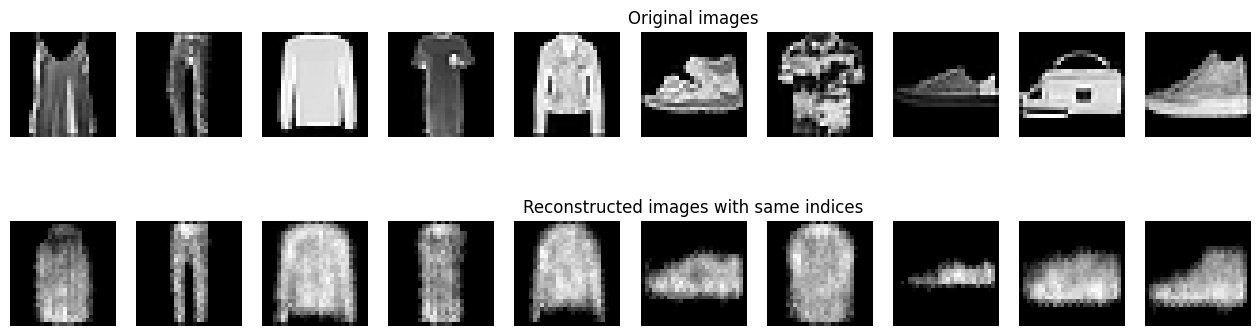

	 partial train loss (single batch): 0.390735
	 partial train loss (single batch): 0.343487
	 partial train loss (single batch): 0.383533
	 partial train loss (single batch): 0.337017
	 partial train loss (single batch): 0.358663
	 partial train loss (single batch): 0.353471
	 partial train loss (single batch): 0.359045
	 partial train loss (single batch): 0.352981
	 partial train loss (single batch): 0.381504
	 partial train loss (single batch): 0.362019
	 partial train loss (single batch): 0.354043
	 partial train loss (single batch): 0.348048
	 partial train loss (single batch): 0.370216
	 partial train loss (single batch): 0.375329
	 partial train loss (single batch): 0.360414
	 partial train loss (single batch): 0.336705
	 partial train loss (single batch): 0.353567
	 partial train loss (single batch): 0.352576
	 partial train loss (single batch): 0.357504
	 partial train loss (single batch): 0.339243
	 partial train loss (single batch): 0.352506
	 partial train loss (single batch

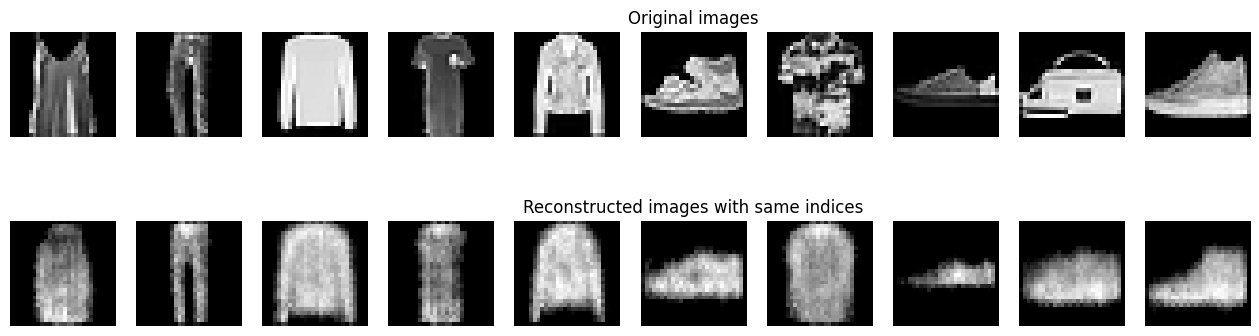

	 partial train loss (single batch): 0.338385
	 partial train loss (single batch): 0.340694
	 partial train loss (single batch): 0.339184
	 partial train loss (single batch): 0.343056
	 partial train loss (single batch): 0.352629
	 partial train loss (single batch): 0.333876
	 partial train loss (single batch): 0.348949
	 partial train loss (single batch): 0.329656
	 partial train loss (single batch): 0.363806
	 partial train loss (single batch): 0.347565
	 partial train loss (single batch): 0.346615
	 partial train loss (single batch): 0.351973
	 partial train loss (single batch): 0.333419
	 partial train loss (single batch): 0.330565
	 partial train loss (single batch): 0.357960
	 partial train loss (single batch): 0.352469
	 partial train loss (single batch): 0.372800
	 partial train loss (single batch): 0.348218
	 partial train loss (single batch): 0.332164
	 partial train loss (single batch): 0.340145
	 partial train loss (single batch): 0.330826
	 partial train loss (single batch

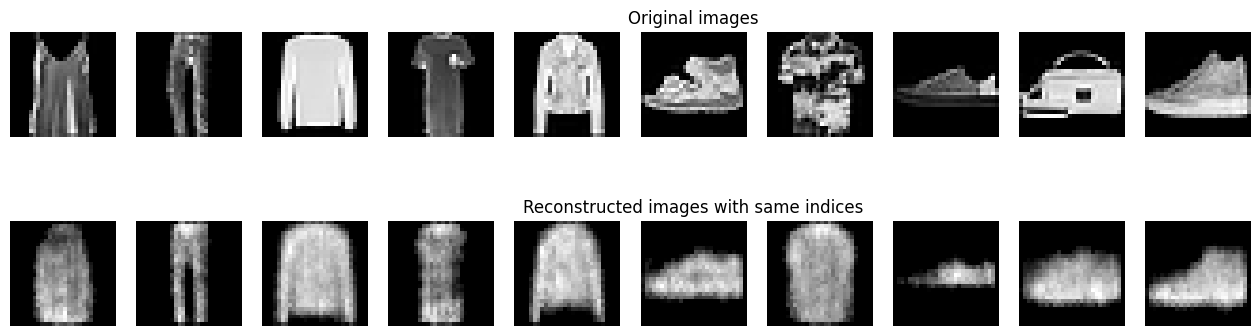

	 partial train loss (single batch): 0.345539
	 partial train loss (single batch): 0.329870
	 partial train loss (single batch): 0.333520
	 partial train loss (single batch): 0.341046
	 partial train loss (single batch): 0.339676
	 partial train loss (single batch): 0.330317
	 partial train loss (single batch): 0.353664
	 partial train loss (single batch): 0.333857
	 partial train loss (single batch): 0.329758
	 partial train loss (single batch): 0.318820
	 partial train loss (single batch): 0.330998
	 partial train loss (single batch): 0.353892
	 partial train loss (single batch): 0.321397
	 partial train loss (single batch): 0.322291
	 partial train loss (single batch): 0.328593
	 partial train loss (single batch): 0.325050
	 partial train loss (single batch): 0.356953
	 partial train loss (single batch): 0.357027
	 partial train loss (single batch): 0.339813
	 partial train loss (single batch): 0.334975
	 partial train loss (single batch): 0.343649
	 partial train loss (single batch

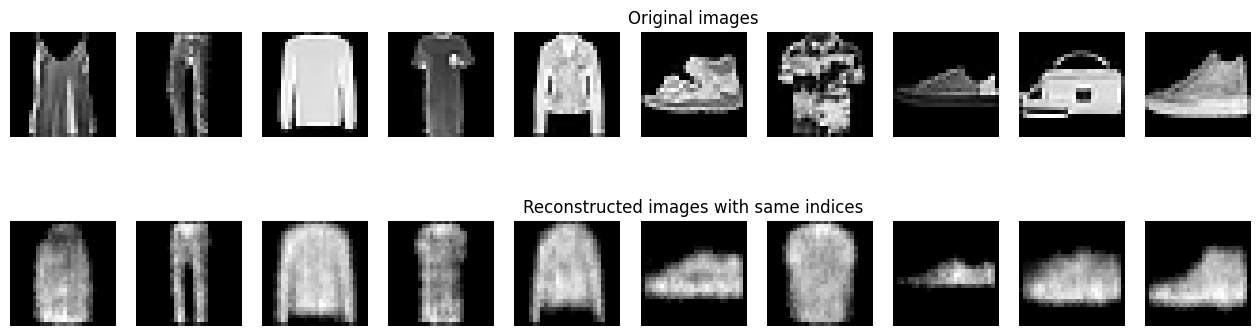

	 partial train loss (single batch): 0.325152
	 partial train loss (single batch): 0.343212
	 partial train loss (single batch): 0.318209
	 partial train loss (single batch): 0.348220
	 partial train loss (single batch): 0.329764
	 partial train loss (single batch): 0.328900
	 partial train loss (single batch): 0.336329
	 partial train loss (single batch): 0.336412
	 partial train loss (single batch): 0.328885
	 partial train loss (single batch): 0.335083
	 partial train loss (single batch): 0.342825
	 partial train loss (single batch): 0.327756
	 partial train loss (single batch): 0.354190
	 partial train loss (single batch): 0.330159
	 partial train loss (single batch): 0.335553
	 partial train loss (single batch): 0.331605
	 partial train loss (single batch): 0.338229
	 partial train loss (single batch): 0.340243
	 partial train loss (single batch): 0.342080
	 partial train loss (single batch): 0.328161
	 partial train loss (single batch): 0.344762
	 partial train loss (single batch

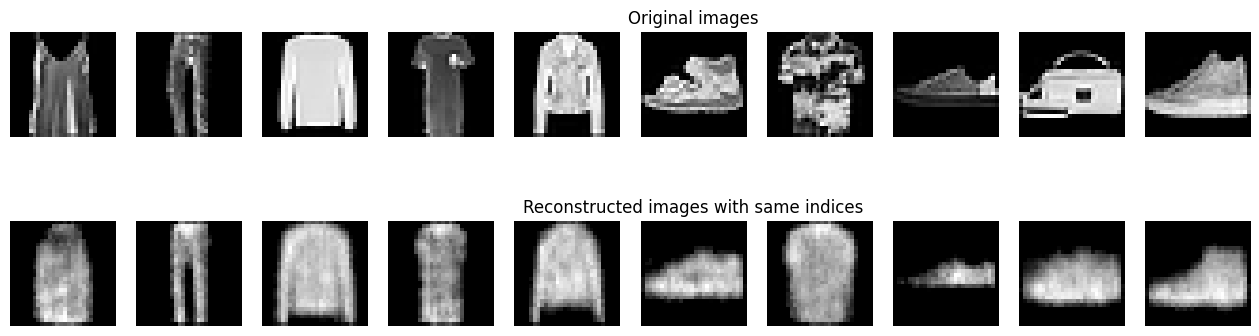

	 partial train loss (single batch): 0.341086
	 partial train loss (single batch): 0.349468
	 partial train loss (single batch): 0.343201
	 partial train loss (single batch): 0.351038
	 partial train loss (single batch): 0.319487
	 partial train loss (single batch): 0.321580
	 partial train loss (single batch): 0.335028
	 partial train loss (single batch): 0.336987
	 partial train loss (single batch): 0.343950
	 partial train loss (single batch): 0.327853
	 partial train loss (single batch): 0.324294
	 partial train loss (single batch): 0.346475
	 partial train loss (single batch): 0.322848
	 partial train loss (single batch): 0.325522
	 partial train loss (single batch): 0.318306
	 partial train loss (single batch): 0.340594
	 partial train loss (single batch): 0.304335
	 partial train loss (single batch): 0.324220
	 partial train loss (single batch): 0.316122
	 partial train loss (single batch): 0.339740
	 partial train loss (single batch): 0.329785
	 partial train loss (single batch

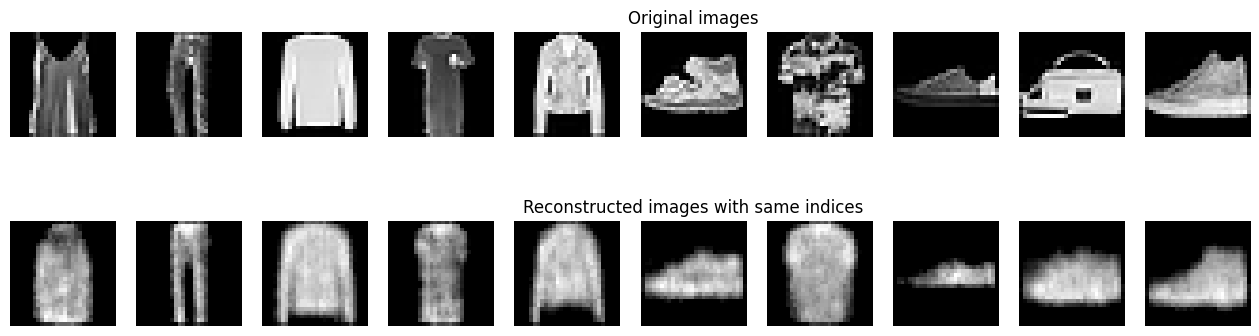

	 partial train loss (single batch): 0.333666
	 partial train loss (single batch): 0.313915
	 partial train loss (single batch): 0.313553
	 partial train loss (single batch): 0.324026
	 partial train loss (single batch): 0.332950
	 partial train loss (single batch): 0.311749
	 partial train loss (single batch): 0.324202
	 partial train loss (single batch): 0.301576
	 partial train loss (single batch): 0.314690
	 partial train loss (single batch): 0.323436
	 partial train loss (single batch): 0.341722
	 partial train loss (single batch): 0.350382
	 partial train loss (single batch): 0.335209
	 partial train loss (single batch): 0.329278
	 partial train loss (single batch): 0.333434
	 partial train loss (single batch): 0.335261
	 partial train loss (single batch): 0.325824
	 partial train loss (single batch): 0.328316
	 partial train loss (single batch): 0.331991
	 partial train loss (single batch): 0.328620
	 partial train loss (single batch): 0.322535
	 partial train loss (single batch

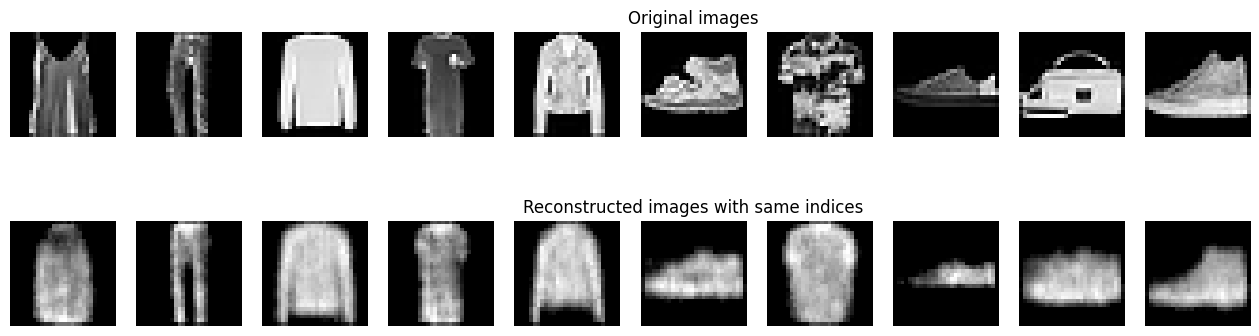

	 partial train loss (single batch): 0.320759
	 partial train loss (single batch): 0.338907
	 partial train loss (single batch): 0.306346
	 partial train loss (single batch): 0.317784
	 partial train loss (single batch): 0.327892
	 partial train loss (single batch): 0.321676
	 partial train loss (single batch): 0.314648
	 partial train loss (single batch): 0.334817
	 partial train loss (single batch): 0.323470
	 partial train loss (single batch): 0.336743
	 partial train loss (single batch): 0.321396
	 partial train loss (single batch): 0.338598
	 partial train loss (single batch): 0.327396
	 partial train loss (single batch): 0.321480
	 partial train loss (single batch): 0.321496
	 partial train loss (single batch): 0.321122
	 partial train loss (single batch): 0.330002
	 partial train loss (single batch): 0.329701
	 partial train loss (single batch): 0.334864
	 partial train loss (single batch): 0.312437
	 partial train loss (single batch): 0.319348
	 partial train loss (single batch

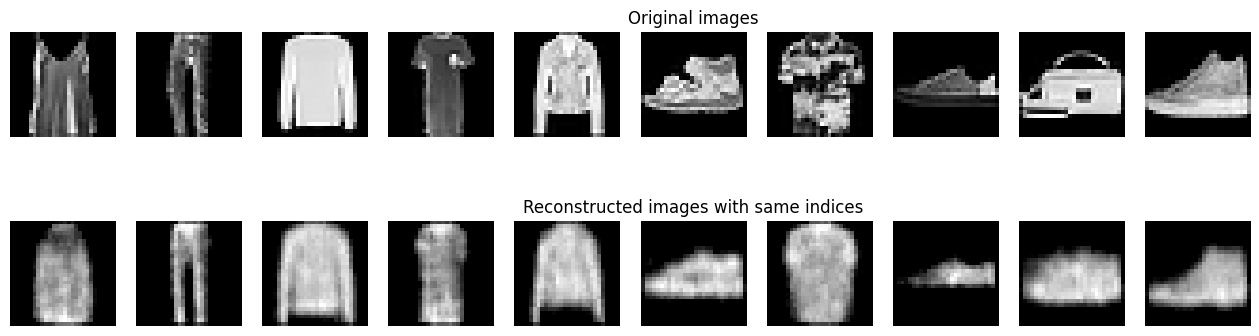

	 partial train loss (single batch): 0.337097
	 partial train loss (single batch): 0.351000
	 partial train loss (single batch): 0.317079
	 partial train loss (single batch): 0.331183
	 partial train loss (single batch): 0.349557
	 partial train loss (single batch): 0.324097
	 partial train loss (single batch): 0.314932
	 partial train loss (single batch): 0.329315
	 partial train loss (single batch): 0.322239
	 partial train loss (single batch): 0.332774
	 partial train loss (single batch): 0.327906
	 partial train loss (single batch): 0.332883
	 partial train loss (single batch): 0.319872
	 partial train loss (single batch): 0.320931
	 partial train loss (single batch): 0.314957
	 partial train loss (single batch): 0.326616
	 partial train loss (single batch): 0.327621
	 partial train loss (single batch): 0.325338
	 partial train loss (single batch): 0.308788
	 partial train loss (single batch): 0.322230
	 partial train loss (single batch): 0.331260
	 partial train loss (single batch

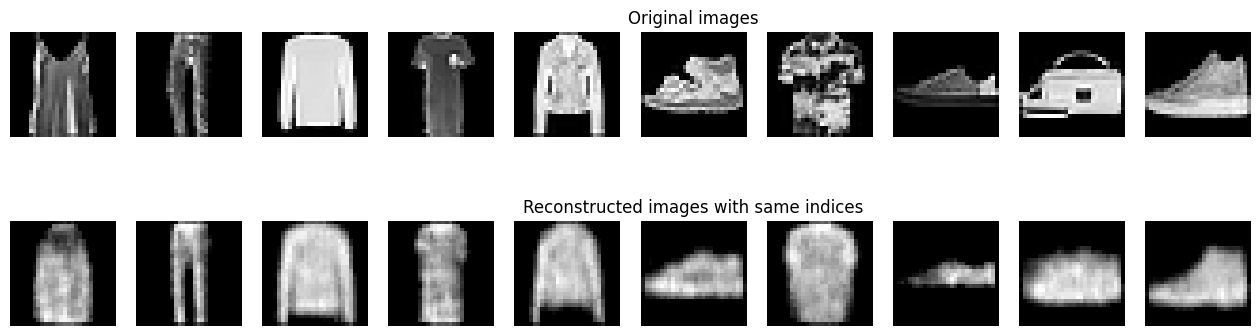

	 partial train loss (single batch): 0.327906
	 partial train loss (single batch): 0.326565
	 partial train loss (single batch): 0.320429
	 partial train loss (single batch): 0.339337
	 partial train loss (single batch): 0.324116
	 partial train loss (single batch): 0.300327
	 partial train loss (single batch): 0.321366
	 partial train loss (single batch): 0.310751
	 partial train loss (single batch): 0.325566
	 partial train loss (single batch): 0.326579
	 partial train loss (single batch): 0.308685
	 partial train loss (single batch): 0.323457
	 partial train loss (single batch): 0.320870
	 partial train loss (single batch): 0.324692
	 partial train loss (single batch): 0.311606
	 partial train loss (single batch): 0.337077
	 partial train loss (single batch): 0.321872
	 partial train loss (single batch): 0.323928
	 partial train loss (single batch): 0.318113
	 partial train loss (single batch): 0.313126
	 partial train loss (single batch): 0.319030
	 partial train loss (single batch

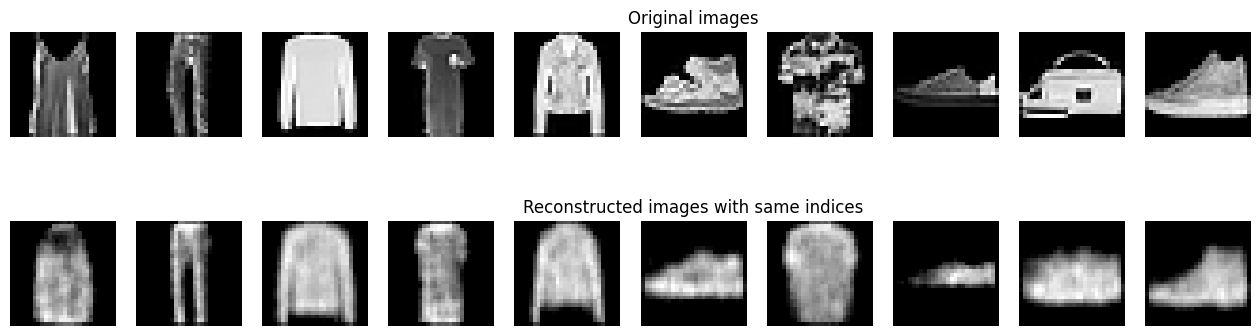

	 partial train loss (single batch): 0.330902
	 partial train loss (single batch): 0.314857
	 partial train loss (single batch): 0.315056
	 partial train loss (single batch): 0.318082
	 partial train loss (single batch): 0.309173
	 partial train loss (single batch): 0.326435
	 partial train loss (single batch): 0.311237
	 partial train loss (single batch): 0.308583
	 partial train loss (single batch): 0.342478
	 partial train loss (single batch): 0.315912
	 partial train loss (single batch): 0.311664
	 partial train loss (single batch): 0.317410
	 partial train loss (single batch): 0.312731
	 partial train loss (single batch): 0.309049
	 partial train loss (single batch): 0.320452
	 partial train loss (single batch): 0.324513
	 partial train loss (single batch): 0.319976
	 partial train loss (single batch): 0.317927
	 partial train loss (single batch): 0.315806
	 partial train loss (single batch): 0.315814
	 partial train loss (single batch): 0.320008
	 partial train loss (single batch

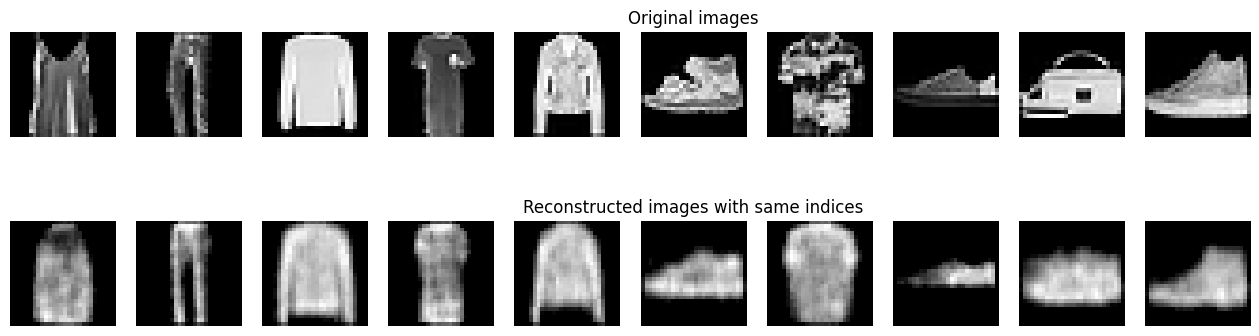

	 partial train loss (single batch): 0.309677
	 partial train loss (single batch): 0.321768
	 partial train loss (single batch): 0.319557
	 partial train loss (single batch): 0.315082
	 partial train loss (single batch): 0.326506
	 partial train loss (single batch): 0.340891
	 partial train loss (single batch): 0.314306
	 partial train loss (single batch): 0.342651
	 partial train loss (single batch): 0.316392
	 partial train loss (single batch): 0.317897
	 partial train loss (single batch): 0.308108
	 partial train loss (single batch): 0.330936
	 partial train loss (single batch): 0.309219
	 partial train loss (single batch): 0.314913
	 partial train loss (single batch): 0.323460
	 partial train loss (single batch): 0.307364
	 partial train loss (single batch): 0.312394
	 partial train loss (single batch): 0.310726
	 partial train loss (single batch): 0.318315
	 partial train loss (single batch): 0.328979
	 partial train loss (single batch): 0.313946
	 partial train loss (single batch

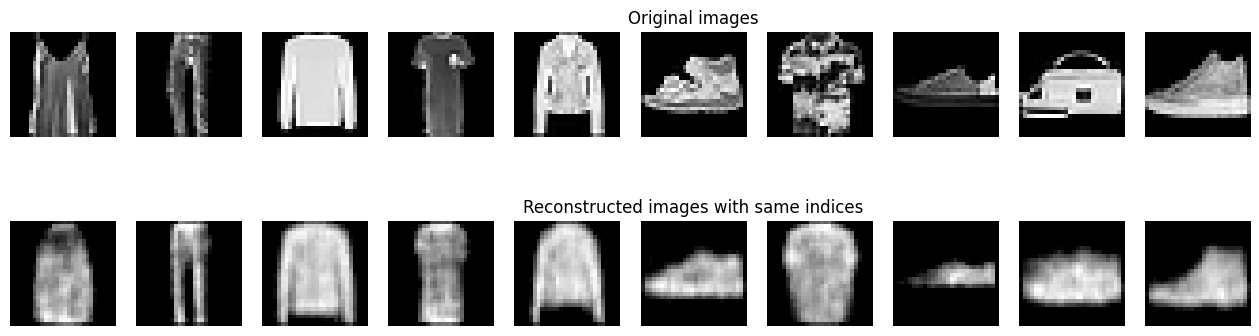

	 partial train loss (single batch): 0.323798
	 partial train loss (single batch): 0.323146
	 partial train loss (single batch): 0.320169
	 partial train loss (single batch): 0.323109
	 partial train loss (single batch): 0.318032
	 partial train loss (single batch): 0.298401
	 partial train loss (single batch): 0.322531
	 partial train loss (single batch): 0.318465
	 partial train loss (single batch): 0.319017
	 partial train loss (single batch): 0.300104
	 partial train loss (single batch): 0.306849
	 partial train loss (single batch): 0.310443
	 partial train loss (single batch): 0.320926
	 partial train loss (single batch): 0.320824
	 partial train loss (single batch): 0.329849
	 partial train loss (single batch): 0.314157
	 partial train loss (single batch): 0.343053
	 partial train loss (single batch): 0.316327
	 partial train loss (single batch): 0.309637
	 partial train loss (single batch): 0.329457
	 partial train loss (single batch): 0.316843
	 partial train loss (single batch

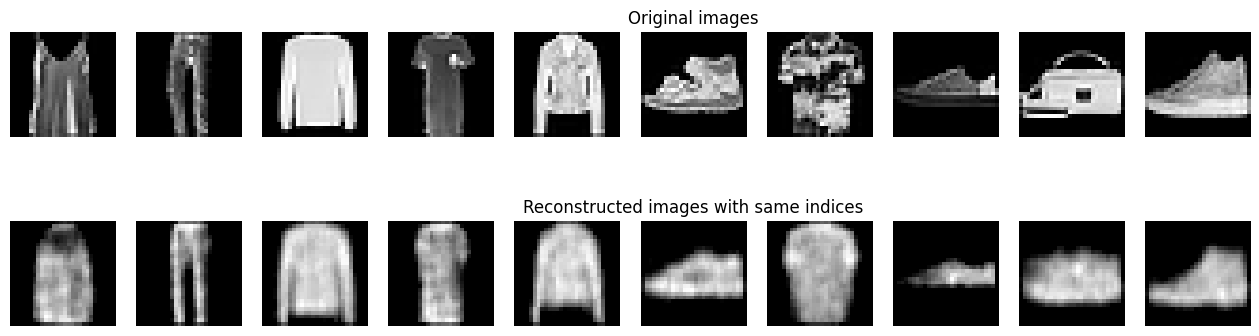

	 partial train loss (single batch): 0.309349
	 partial train loss (single batch): 0.311526
	 partial train loss (single batch): 0.314618
	 partial train loss (single batch): 0.310692
	 partial train loss (single batch): 0.334862
	 partial train loss (single batch): 0.320757
	 partial train loss (single batch): 0.338572
	 partial train loss (single batch): 0.318248
	 partial train loss (single batch): 0.307222
	 partial train loss (single batch): 0.322074
	 partial train loss (single batch): 0.320387
	 partial train loss (single batch): 0.317635
	 partial train loss (single batch): 0.330749
	 partial train loss (single batch): 0.300645
	 partial train loss (single batch): 0.304484
	 partial train loss (single batch): 0.317964
	 partial train loss (single batch): 0.332531
	 partial train loss (single batch): 0.300561
	 partial train loss (single batch): 0.316073
	 partial train loss (single batch): 0.322809
	 partial train loss (single batch): 0.325567
	 partial train loss (single batch

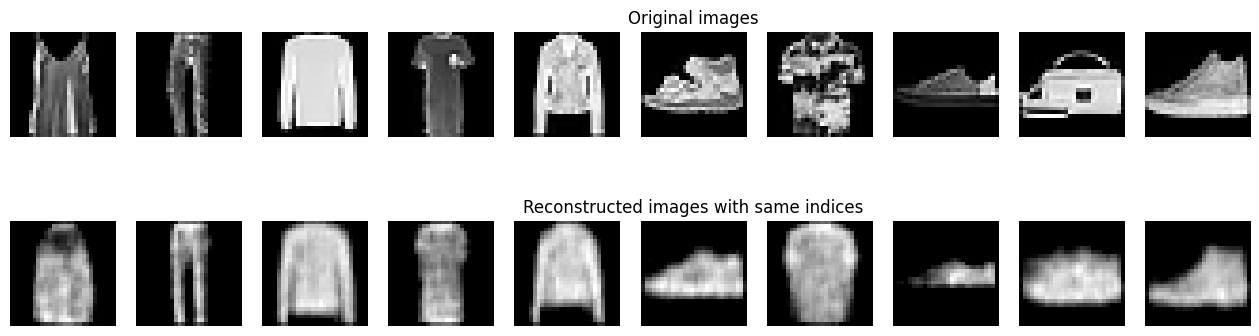

	 partial train loss (single batch): 0.322381
	 partial train loss (single batch): 0.306656
	 partial train loss (single batch): 0.306714
	 partial train loss (single batch): 0.341894
	 partial train loss (single batch): 0.299173
	 partial train loss (single batch): 0.314700
	 partial train loss (single batch): 0.294875
	 partial train loss (single batch): 0.324961
	 partial train loss (single batch): 0.313611
	 partial train loss (single batch): 0.315310
	 partial train loss (single batch): 0.302539
	 partial train loss (single batch): 0.315078
	 partial train loss (single batch): 0.322092
	 partial train loss (single batch): 0.318723
	 partial train loss (single batch): 0.294886
	 partial train loss (single batch): 0.306430
	 partial train loss (single batch): 0.302763
	 partial train loss (single batch): 0.342198
	 partial train loss (single batch): 0.313531
	 partial train loss (single batch): 0.303155
	 partial train loss (single batch): 0.328088
	 partial train loss (single batch

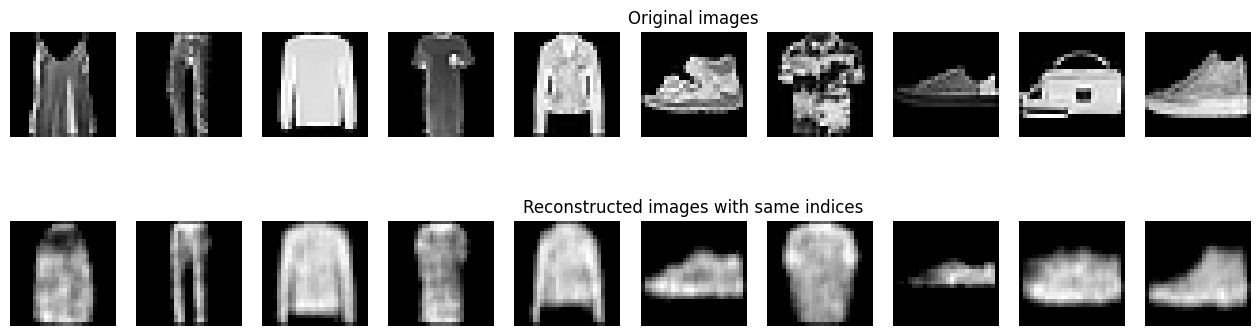

In [223]:

num_epochs = 20
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   #plot_ae_outputs_random_indx(encoder,decoder,test_dataset, device,n=10)
   plot_ae_outputs_same_set(encoder,decoder,test_dataset, device, fixed_indices)


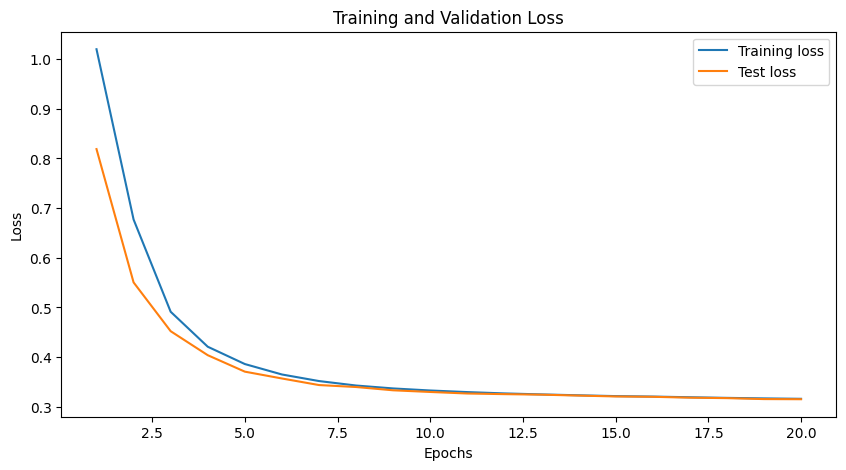

In [225]:
import matplotlib.pyplot as plt
import torch

def plot_losses(diz_loss):
    train_losses = diz_loss['train_loss']
    val_losses = diz_loss['val_loss']
    epochs = range(1, len(train_losses) + 1)

    # Check if elements are tensors and convert them to CPU NumPy arrays
    train_losses = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
    val_losses = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training loss')
    plt.plot(epochs, val_losses, label='Test loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function with your dictionary
plot_losses(diz_loss)


In [297]:
encoded_space_dim = 64
encoder_3 = Encoder_3(encoded_space_dim=encoded_space_dim)
decoder_3= Decoder_3(encoded_space_dim=encoded_space_dim)
encoder_3.to(device)
decoder_3.to(device)

Decoder_3(
  (decoder_lin): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 4, 4))
  (upconv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (final_conv): Sequential(
    (0): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [299]:
encoder_3

Encoder_3(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
)

In [300]:
decoder_3

Decoder_3(
  (decoder_lin): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 4, 4))
  (upconv1): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (upconv2): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (final_conv): Sequential(
    (0): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
)

In [301]:
encoder_params = sum([p.numel() for p in encoder_3.parameters() if p.requires_grad])

In [302]:
encoder_params

41344

In [303]:
decoder_params = sum([p.numel() for p in decoder_3.parameters() if p.requires_grad])

In [304]:
decoder_params

45899

In [217]:
torch.__version__

'2.1.0+cu121'

Shape after encoder cnn: torch.Size([128, 16, 4, 4])
Shape after flatten: torch.Size([128, 256])
Shape after encoder lin: torch.Size([128, 64])
Shape after decoder lin: torch.Size([128, 256])
Shape after unflatten: torch.Size([128, 16, 4, 4])
Shape after conv1: torch.Size([128, 16, 7, 7])
Shape after conv2: torch.Size([128, 8, 14, 14])
Shape after conv3: torch.Size([128, 1, 28, 28])
	 partial train loss (single batch): 1.552973
Shape after encoder cnn: torch.Size([128, 16, 4, 4])
Shape after flatten: torch.Size([128, 256])
Shape after encoder lin: torch.Size([128, 64])
Shape after decoder lin: torch.Size([128, 256])
Shape after unflatten: torch.Size([128, 16, 4, 4])
Shape after conv1: torch.Size([128, 16, 7, 7])
Shape after conv2: torch.Size([128, 8, 14, 14])
Shape after conv3: torch.Size([128, 1, 28, 28])
	 partial train loss (single batch): 1.650325
Shape after encoder cnn: torch.Size([128, 16, 4, 4])
Shape after flatten: torch.Size([128, 256])
Shape after encoder lin: torch.Size([12

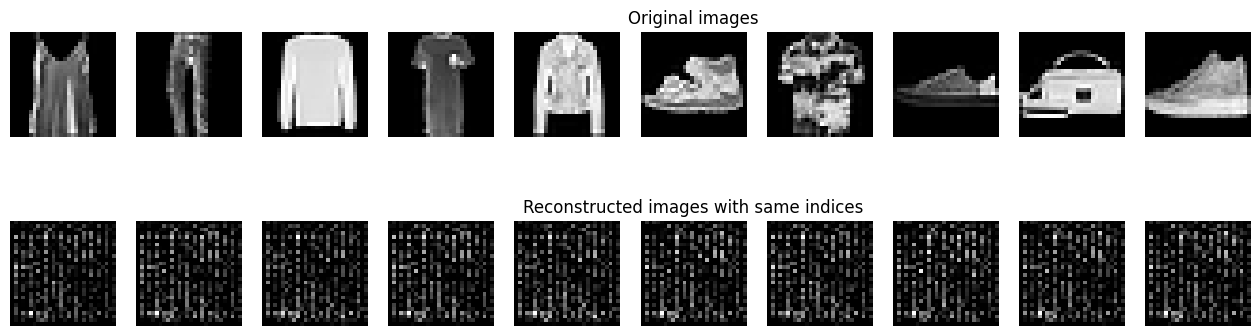

Shape after encoder cnn: torch.Size([128, 16, 4, 4])
Shape after flatten: torch.Size([128, 256])
Shape after encoder lin: torch.Size([128, 64])
Shape after decoder lin: torch.Size([128, 256])
Shape after unflatten: torch.Size([128, 16, 4, 4])
Shape after conv1: torch.Size([128, 16, 7, 7])
Shape after conv2: torch.Size([128, 8, 14, 14])
Shape after conv3: torch.Size([128, 1, 28, 28])
	 partial train loss (single batch): 1.587957
Shape after encoder cnn: torch.Size([128, 16, 4, 4])
Shape after flatten: torch.Size([128, 256])
Shape after encoder lin: torch.Size([128, 64])
Shape after decoder lin: torch.Size([128, 256])
Shape after unflatten: torch.Size([128, 16, 4, 4])
Shape after conv1: torch.Size([128, 16, 7, 7])
Shape after conv2: torch.Size([128, 8, 14, 14])
Shape after conv3: torch.Size([128, 1, 28, 28])
	 partial train loss (single batch): 1.594990
Shape after encoder cnn: torch.Size([128, 16, 4, 4])
Shape after flatten: torch.Size([128, 256])
Shape after encoder lin: torch.Size([12

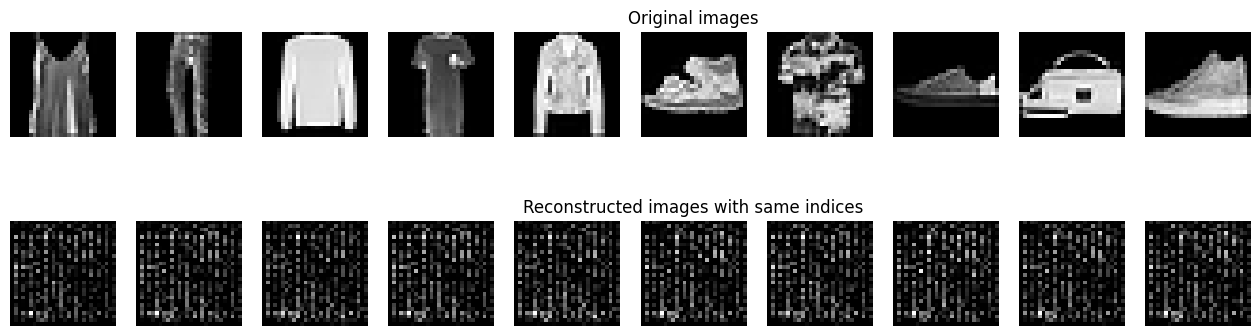

Shape after encoder cnn: torch.Size([128, 16, 4, 4])
Shape after flatten: torch.Size([128, 256])
Shape after encoder lin: torch.Size([128, 64])
Shape after decoder lin: torch.Size([128, 256])
Shape after unflatten: torch.Size([128, 16, 4, 4])
Shape after conv1: torch.Size([128, 16, 7, 7])
Shape after conv2: torch.Size([128, 8, 14, 14])
Shape after conv3: torch.Size([128, 1, 28, 28])
	 partial train loss (single batch): 1.680014
Shape after encoder cnn: torch.Size([128, 16, 4, 4])
Shape after flatten: torch.Size([128, 256])
Shape after encoder lin: torch.Size([128, 64])
Shape after decoder lin: torch.Size([128, 256])
Shape after unflatten: torch.Size([128, 16, 4, 4])
Shape after conv1: torch.Size([128, 16, 7, 7])
Shape after conv2: torch.Size([128, 8, 14, 14])
Shape after conv3: torch.Size([128, 1, 28, 28])
	 partial train loss (single batch): 1.662847
Shape after encoder cnn: torch.Size([128, 16, 4, 4])
Shape after flatten: torch.Size([128, 256])
Shape after encoder lin: torch.Size([12

KeyboardInterrupt: ignored

In [305]:

num_epochs = 20
diz_loss_model_3 = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss_model_3 = train_epoch(encoder_3,decoder_3,device,
   train_loader,loss_fn,optim)
   val_loss_model_3 = test_epoch(encoder_3,decoder_3,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss_model_3['train_loss'].append(train_loss_model_3)
   diz_loss_model_3['val_loss'].append(val_loss_model_3)
   plot_ae_outputs_same_set(encoder_3,decoder_3,test_dataset, device,fixed_indices)